**Example maaslin + pathways workflow**

In [48]:
# load the maaslin3 package
library(maaslin3)
# read metadata
meta <- read.csv("../data/metadatav2.txt", sep = '\t', row.names=1)
meta$tbClass <- trimws(meta$tbClass, which = "right")

meta <- meta[meta$savio_id != "", ]
meta$sample <- sub("_R.*\\.fastq\\.gz$", "", meta$savio_id)
# read humann pathway abundances 
pathabundance <- read.table(
  '../data/pathabundance_all.tsv',
  sep = '\t', # tab-delimited
  row.names = 1, # first column is row names
  check.names = FALSE, # current sample names are not R-safe, this tells R to not change them
  header = TRUE,  # first row is a header
  comment.char = '', # ignore the top line (starts with #)
   quote='' # ignore quotes
)
colnames(pathabundance) <- sub("_Abundance$", "", colnames(pathabundance))
## check intersection of samples between humann and metadata
cat("only in humann:", length(setdiff(colnames(pathabundance), meta$sample)), "\n")
cat("only in metadata:", length(setdiff(meta$sample, colnames(pathabundance))), "\n")
shared_samples <- intersect(colnames(pathabundance), meta$sample)
cat("shared samples:", length(shared_samples), "\n")
rownames(meta) <- meta$sample
meta <- meta[shared_samples, ]
pathabundance <- pathabundance[, shared_samples]

## pull out cross-taxa and by-taxa pathway abundances ( you could keep these together, but I like to separate them)
cross_taxa <- pathabundance[!grepl("\\|", rownames(pathabundance)),]
by_taxa <- pathabundance[grepl("\\|", rownames(pathabundance)) | rownames(pathabundance) == "UNMAPPED",]
# Normalize  to sum to 1M per sample, fill NAs with 0
cross_taxa <- sweep(cross_taxa, 2, colSums(cross_taxa), '/') * 1000000
cross_taxa[is.na(cross_taxa)] <- 0
by_taxa <- sweep(by_taxa, 2, colSums(by_taxa), '/') * 1000000
by_taxa[is.na(by_taxa)] <- 0
## filter out rows (pathways) that are not found in any samples
by_taxa <- by_taxa[rowSums(by_taxa) != 0, ]
cross_taxa <- cross_taxa[rowSums(cross_taxa) != 0, ]

only in humann: 48 
only in metadata: 27 
shared samples: 203 


**take a look at the values in metadata**

In [49]:
for (col in setdiff(colnames(meta), c("sample_id",'savio_id','sample', 'age'))) {
  cat("Value counts for", col, ":\n")
  print(table(meta[[col]], useNA = "ifany"))
  cat("\n")
}

Value counts for tbClass :

     Confirmed Unclassifiable    Unconfirmed       Unlikely          avium 
            33              9            102             48              1 
       control            mix            mtb          spike 
             3              1              1              5 

Value counts for ntm :

         Negative Positive 
      18      174       11 

Value counts for sex :

      F   M 
 11  87 105 

Value counts for age_range :

        over1 under1 
    11    159     33 

Value counts for childhood :

           adolescent      early     infant     middle 
        11         10         90         33         59 

Value counts for hiv :

            HIV-exposed    Negative    Positive 
         24           6         144          29 

Value counts for sam :

      N   P 
 11 172  20 

Value counts for underweight :

    N  P 
11 96 96 



**for the example fit, focusing on confirmed vs unlikely cases in the over1 population**

In [38]:
table(subset(meta, meta$age_range=='over1')[['tbClass']], useNA = "ifany")


    Confirmed  Unclassifiable   Unconfirmed        Unlikely 
            25              7             87             40 

In [39]:
table(subset(meta, meta$age_range=='over1')[['underweight']], useNA = "ifany")


 N  P 
79 80 

**example maaslin fit**
- tbClass confirmed vs unconfirmed among children over 1
- control for underweight and sex

In [55]:
## create a directory to store the output
maaslin_dir <- '../data/maaslin_fits/'
if (!dir.exists(maaslin_dir)) dir.create(maaslin_dir, recursive=TRUE)

## pull the rows out of the metadata that we want
meta_sub <- subset(meta, tbClass %in% c("Confirmed", "Unlikely") & age_range == "over1")

## run the cross-taxa pathways
over1_tb <- maaslin3(input_data = cross_taxa, input_metadata = meta_sub,
                    output = paste0(maaslin_dir,'over1_cross_taxa'),
                     formula = "~ tbClass + (1|sex)",
                    normalization = 'TSS', transform = 'LOG', augment=TRUE,
                    standardize=TRUE, max_significance=0.05, median_comparison_abundance=TRUE,
                    median_comparison_prevalence=FALSE, max_pngs =200, cores=10, min_prevalence = 0.3)
## run the by-taxa pathways
# over1_tb_bytaxa <- maaslin3(input_data = by_taxa, input_metadata = meta_sub,
#                     output = paste0(maaslin_dir, 'over1_by_taxa'),
#                      formula = "~ tbClass + underweight + (1|sex)",
#                     normalization = 'TSS', transform = 'LOG', augment=TRUE,
#                     standardize=TRUE, max_significance=0.05, median_comparison_abundance=TRUE,
#                     median_comparison_prevalence=FALSE, max_pngs =200, cores=12, min_prevalence = 0.3)

2025-09-25 07:40:50.097408 INFO::Writing function arguments to log file
2025-09-25 07:40:50.106235 INFO::Verifying options selected are valid
2025-09-25 07:40:50.106759 INFO::Determining format of input files
2025-09-25 07:40:50.107049 INFO::Input format is data samples as columns and metadata samples as rows
2025-09-25 07:40:50.110213 INFO::The following samples were found to have features but no metadata (or feature specific covariates if applicable). They will be removed. LIB003301_22C2NCLT3_S20_L003,LIB003304_22C2NCLT3_S17_L003,LIB003307_22C2NCLT3_S14_L003,LIB061830_22H3KFLT4_S1_L007,LIB061832_22H3KFLT4_S3_L007,LIB061833_22H3KFLT4_S4_L007,LIB061834_22H3KFLT4_S5_L007,LIB061837_22H3KFLT4_S8_L007,LIB061838_22H3KFLT4_S9_L007,LIB061839_22H3KFLT4_S10_L007,LIB061840_22H3KFLT4_S11_L007,LIB061841_22H3KFLT4_S12_L007,LIB061842_22H3KFLT4_S13_L007,LIB061844_22H3KFLT4_S15_L007,LIB061845_22H3KFLT4_S16_L007,LIB061846_22H3KFLT4_S17_L007,LIB061847_22H3KFLT4_S18_L007,LIB061849_22H3KFLT4_S20_L007,LIB0

**look at the top results -- nothing significant**

In [56]:
cross_results <- read.csv(paste0(maaslin_dir, 'over1_cross_taxa/all_results.tsv'), sep = '\t')
#by_results <- read.csv(paste0(maaslin_dir, 'over1_by_taxa/all_results.tsv'), sep = '\t')

cross taxa

In [57]:
head(cross_results[,c('feature', 'name', 'coef', 'pval_individual', 'qval_individual', 'model', 'N_not_zero')])

,feature,name,coef,pval_individual,qval_individual,model,N_not_zero
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,1CMET2-PWY: folate transformations III (E. coli),tbClassUnlikely,0.1300263,0.016474768,0.4960191,abundance,58
2,ANAEROFRUCAT-PWY: homolactic fermentation,tbClassUnlikely,0.2921681,0.007008326,0.4960191,abundance,59
3,ARGSYN-PWY: L-arginine biosynthesis I (via L-ornithine),tbClassUnlikely,0.1535179,0.039458633,0.4960191,abundance,59
4,ARGSYNBSUB-PWY: L-arginine biosynthesis II (acetyl cycle),tbClassUnlikely,0.1597464,0.044654370,0.4960191,abundance,59
5,ARO-PWY: chorismate biosynthesis I,tbClassUnlikely,0.1070207,0.069283092,0.4960191,abundance,59
6,CENTFERM-PWY: pyruvate fermentation to butanoate,tbClassUnlikely,0.7076396,0.032065142,0.4960191,abundance,37


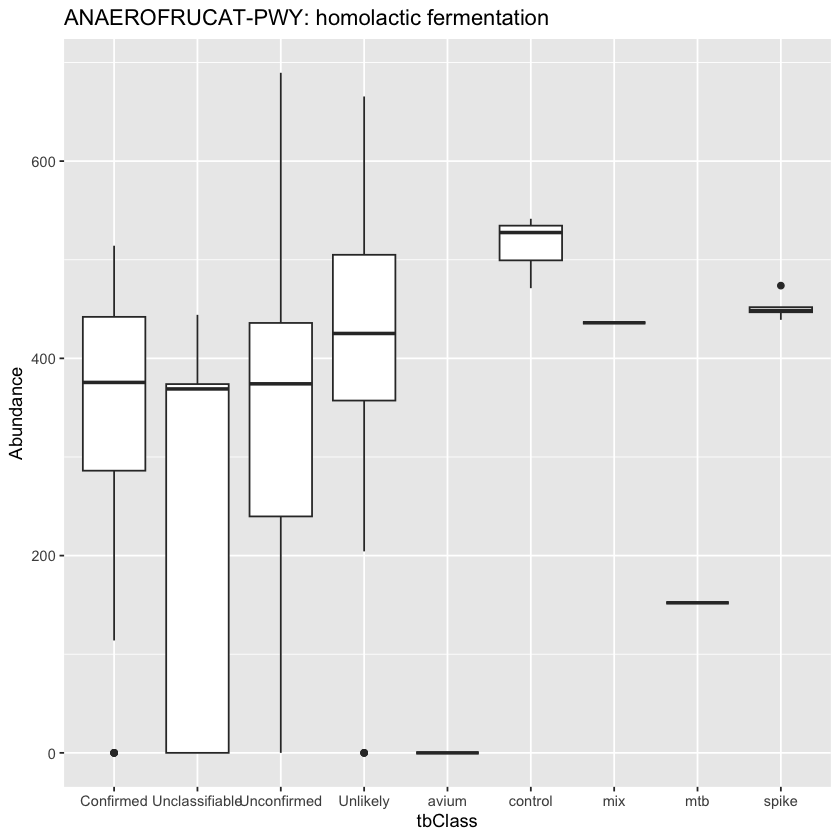

In [59]:
library(ggplot2)
feature_name <- "ANAEROFRUCAT-PWY: homolactic fermentation"
feature_values <- cross_taxa[feature_name, ]
df <- data.frame(
  value = as.numeric(feature_values),
  tbClass = meta$tbClass
)
ggplot(df, aes(x = tbClass, y = value)) +
  geom_boxplot() +
  labs(title = feature_name, x = "tbClass", y = "Abundance")
